## Загрузите датасет breast_cancer.


In [3]:
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold, StratifiedShuffleSplit
from scipy.stats import sem
from sklearn.metrics import r2_score,classification_report, f1_score, confusion_matrix


In [4]:

 
breast_cancer = load_breast_cancer()
 
X = breast_cancer.data
y = breast_cancer.target


## Разделите выборку на обучающую и тестовую в пропорции 70-30. Шаги 3-7 выполняйте на обучающей выборке.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = 0.7, random_state=12)

## Создайте конвейер, состоящий из классификатора на основе наивного Линейного SVM.

In [7]:
clf = Pipeline([
    ('svc', SVC(kernel="linear",probability=True)),
])


### Познакомьтесь с документацией по классу KFold и методу cross_val_score из модуля model_selection для организации перекрестной проверки.

### Используйте данные функции для вычисления робастной оценки эффективности созданного на шаге 3 классификатора на датасете из шага 1.

In [8]:
def evaluate_cross_validation(clf, X, y, K):
    cv = KFold(K, shuffle=True, random_state=0).get_n_splits(len(y))
    scores = cross_val_score(clf, X, y, cv=cv)
    print(scores)
    print(("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores)))
    return np.mean(scores)
 
mean_score = evaluate_cross_validation(clf, X, y, 3)
print(mean_score)

[0.93684211 0.96842105 0.94708995]
Mean score: 0.951 (+/-0.009)
0.950784368328228


достаточно хороший mean score



### Напишите функцию, которая подбирает оптимальное значение гиперпараметра регуляризации (alpha) ориентируясь на наилучшее значение робастной эффективности. Для этого познакомьтесь с функцией set_params


Для проверки различных значений гиперпараметров сформируем список и напишем функцию calc_params, которая принимает матрицу признаков, вектор целевой переменной (сюда нужно будет передавать обучающую выборку, полученную на втором шаге), список значений параметра и название этого параметра

### Постройте график зависимости обучающей и тестовой оценки классификатора от значения параметра alpha

In [91]:
def calc_param(X,y,clf,params,param_name,K):
    train_scores = []
    test_scores = []
    
    for i in range(len(params)):
        print(i)
        cv = KFold(K, shuffle=True, random_state=0).split(X, y)
        clf.set_params(**{param_name:params[i]})
        test = [None] * K
        train = [None] * K
        for j, (train, test) in enumerate(cv):
            print('j = ',j)
            k_train_scores = np.zeros(K)
            k_test_scores = np.zeros(K)
        
        # fit the classifier in the corresponding fold
        # and obtain the corresponding accuracy scores on train and test sets
            clf.fit([X[k] for k in train], y[train])
            k_train_scores[j] = clf.score([X[k] for k in train], y[train])
            k_test_scores[j] = clf.score([X[k] for k in test], y[test])
            #print('mean.   ',np.mean(k_train_scores[j]))
            #print(k_test_scores)
        train = k_train_scores.sum()
        train_scores.append(train)
        test = k_test_scores.sum()
        test_scores.append(test)
    
    dictionary = dict(zip(params, test_scores))
    best_param = max(dictionary.items(), key=operator.itemgetter(1))[0]
    clf.set_params(**{param_name:best_param})
    print('Best',param_name,':', best_param)
    
    plt.figure(figsize=(10, 5))
    plt.plot(params,train_scores, label="training scores")
    plt.plot(params,test_scores, label="test scores")
    plt.legend(loc="lower right")
    plt.ylabel('Mean cross-validation accuracy')
    plt.xlabel(param_name)
    plt.show
    
    

0
j =  0
j =  1
j =  2
1
j =  0
j =  1
j =  2
2
j =  0
j =  1
j =  2
3
j =  0
j =  1
j =  2
4
j =  0
j =  1
j =  2
5
j =  0
j =  1
j =  2
Best svc__C : 100.0


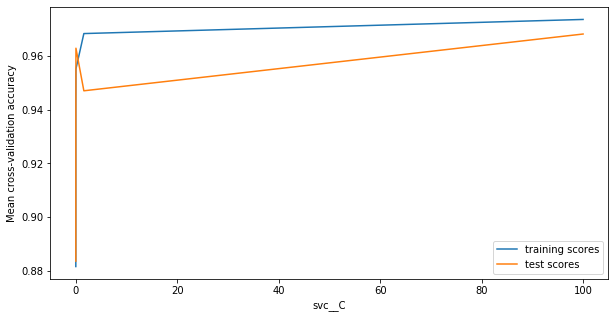

In [93]:
alphas = np.logspace(-7, 2, 6)
calc_param(X, y, clf, alphas, 'svc__C',3)

Не обращайте внимание на цифры, я просто отслеживала иттерации

Я правда взяла меньше значений альфа, а то очень долго считал и мой ноутбук пыхтел

параметр подбирается исходя из лучшего значения для валдиационной выборки

### Используйте несколько метрик эффективности для оценки полученного классификатора (с наилучшим значением гиперпараметра). Прокомментируйте получившиеся значения.


Text(0.5, 15.0, 'Предсказанные значения')

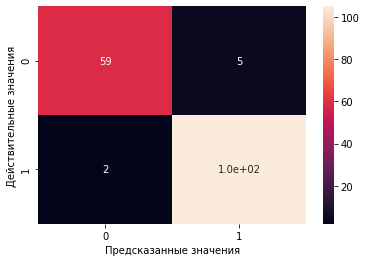

In [253]:
class_names = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)

cf_matrix = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(cf_matrix, annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

In [254]:
clf.fit(X_train,y_train)
clf_report = classification_report(y_test, clf.predict(X_test))
print(clf_report)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        64
           1       0.94      0.98      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



Оценивая classification_report и смотря на получившуюся confusion_matrix, можно понять, что в целом ошибка для определения каждого класса мала, так же исходя из нашей задачи, нам важно оценивать, как много больных людей (по-настоящему) находит алгоритм,то есть наверное  важна метрика recall сильнее, как мы видим, для 1 класса она равна 98%, то есть в целом алгоритм среди всех больных находит только 95%, что в целом достаточно хороший результат, к тому же как мы видим, среди здоровых люлей он мало кому приписывает болезнь, что тоже оченьхороший показатель 

### Постройте кривую усредненного Precision-Recall. Выведите оценку F1. Прокомментируйте результат.

F1-score: 0.958904109589041


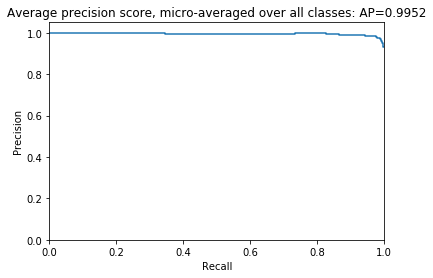

In [257]:
from sklearn.metrics import plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import average_precision_score
 
y_score = clf.decision_function(X)
 
precision, recall, _ = precision_recall_curve(y.ravel(), y_score.ravel())
average_precision = average_precision_score(y, y_score)
 
plt.step(recall, precision, where='post')
 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.4f}'
    .format(average_precision))

print('\033[1mF1-score:\033[0m',f1_score(y_test, clf.predict(X_test)))


Данный график говорит о том, что высок показатель как Recall, тиак и Precision, из-за чего площадь под графиком очень близка к графику идеальной модели, поэтому можно сказать, что с подобранным параметром модель хорошо работает 

Усредненная метрика f1 так же говорит о хорошем качестве полученной модели

### Постройте кривую ROC. Выведите метрику ROC-AUC. Прокомментируйте результат. 


In [258]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='red', label='ROC , auc='+str(round(auc,2)))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive ')
    plt.ylabel('True Positive ')
    plt.title('Площадь ROC-кривой')
    plt.legend()
    plt.show()

AUC: 0.98584


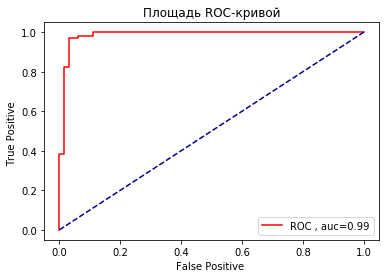

In [259]:
probs = clf.predict_proba(X_test)
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC: %.5f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

Как мы видим построенный график очень близок к углу (0,1), что гооворит о хорошем качестве модели

### Используйте возможности распараллеливания для ускорения обучения. Сделайте замеры времени обучения в однопоточном режиме, в два потока и при количестве потоков равном количеству ядер в Вашей системе. Выведите результаты в таблицу и сделайте вывод.


Взяла как пример RandomForest, потому что там есть параметр n_jobs

In [214]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
%timeit rf.fit(X_train, y_train)


132 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [208]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11,n_jobs =2)
%timeit rf.fit(X_train, y_train)



150 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [215]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11,n_jobs = -1)
%timeit rf.fit(X_train, y_train)

189 ms ± 53.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
%timeit clf.fit(X_train,y_train)

372 ms ± 55.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print('n=1 time =150 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)' )

Как мы видим, при последнем использовании ( при количестве потоков равном количеству ядер в Вашей системе) уменьшается количество loop (loop=1), а значит и ускоряется время обучения

### Повторите анализ для другой модели (вида ядра). Сравните производительности моделей для разных метрик. Сделайте вывод о предпочтительности моделей.


Давайте возьмем другое ядро SVM для сравнения

In [96]:
clf_rbf = Pipeline([
    ('svc', SVC(kernel="rbf",probability=True)),
])

0
j =  0
j =  1
j =  2
1
j =  0
j =  1
j =  2
2
j =  0
j =  1
j =  2
3
j =  0
j =  1
j =  2
4
j =  0
j =  1
j =  2
5
j =  0
j =  1
j =  2
6
j =  0
j =  1
j =  2
7
j =  0
j =  1
j =  2
8
j =  0
j =  1
j =  2
9
j =  0
j =  1
j =  2
10
j =  0
j =  1
j =  2
11
j =  0
j =  1
j =  2
Best svc__C : 15.199110829529332


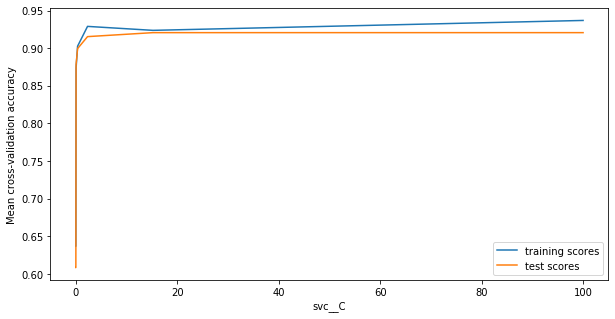

In [98]:
alphas = np.logspace(-7, 2, 12)
calc_param(X, y, clf_rbf, alphas, 'svc__C',3)

In [266]:
%timeit clf_rbf.fit(X_train,y_train)

9.44 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [262]:
clf_rbf.fit(X_train,y_train)
clf_report = classification_report(y_test, clf_rbf.predict(X_test))
print(clf_report)

              precision    recall  f1-score   support

           0       0.93      0.81      0.87        64
           1       0.90      0.96      0.93       107

    accuracy                           0.91       171
   macro avg       0.91      0.89      0.90       171
weighted avg       0.91      0.91      0.90       171



Text(0.5, 15.0, 'Предсказанные значения')

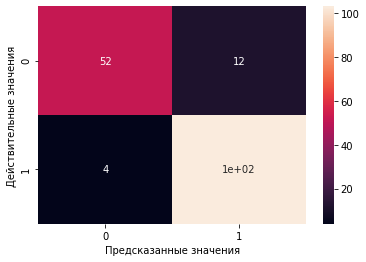

In [263]:
class_names = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)

cf_matrix = confusion_matrix(y_test, clf_rbf.predict(X_test))
sns.heatmap(cf_matrix, annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

F1-score: 0.9279279279279279


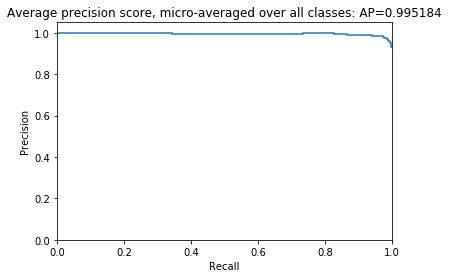

In [264]:
from sklearn.metrics import plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import average_precision_score
 
y_score = clf.decision_function(X)
 
precision, recall, _ = precision_recall_curve(y.ravel(), y_score.ravel())
average_precision = average_precision_score(y, y_score)
 
plt.step(recall, precision, where='post')
 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.6f}'
    .format(average_precision))

print('\033[1mF1-score:\033[0m',f1_score(y_test, clf_rbf.predict(X_test)))

AUC: 0.97722


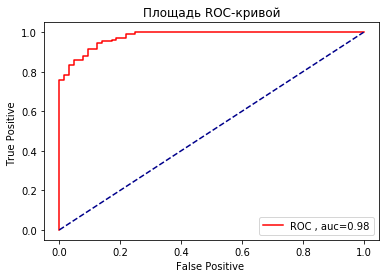

In [265]:
probs = clf_rbf.predict_proba(X_test)
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC: %.5f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

Как мы видим, svc модель с данным ядром незначительно хуже модели с линейным ядром, но отличается буквально не намного, но при этом данна модель быстрее обучается, так что при анализе больших данных можно пожертвовать качеством модели на какие-то сотые единицы ради времени вычисления 